In [21]:
import pandas as pd
import numpy as np
import json
import nltk
import string
import re
import sys
sys.path.append("../")
from scripts.start import iberEval, sexists
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import homogeneity_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Import data

In [2]:
tweets, categories = iberEval()

In [142]:
np.unique(categories)

array(['derailing', 'discredit', 'dominance', 'sexual_harassment',
       'stereotype'], dtype='<U17')

In [143]:
from collections import Counter
Counter(categories)

Counter({'discredit': 943,
         'sexual_harassment': 410,
         'derailing': 29,
         'stereotype': 137,
         'dominance': 49})

## Preprocess & build TFIDF

In [31]:
def tokenize_and_lemmatize(text):
    text = re.sub("[@]\w+", "", text) # remove tags
    # remove punctuation
    table = text.maketrans({key: None for key in string.punctuation})
    text = text.translate(table)
    text = re.sub("(http)\w+", "", text) # remove links
    tokens = nltk.word_tokenize(text)
    #lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

In [32]:
lemmatizer = WordNetLemmatizer()
englishwords = stopwords.words('english')

In [103]:
#try multi-grams?
tfidf_vec = TfidfVectorizer(max_df=0.95, 
                        max_features=10000,
                        min_df=5, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize, 
                        ngram_range=(1,3))

In [104]:
tfidf_mat = tfidf_vec.fit_transform(tweets)
tfidf_mat.shape

(1568, 591)

## K-Means clustering, keyword extraction & visualization

In [35]:
clusters = MiniBatchKMeans(n_clusters=5, init_size=1024, batch_size=2048, random_state=20).fit_predict(tfidf_mat)

In [36]:
def plot_tsne_pca(data, labels,defLabels=None):
    max_label = max(labels)
    
    pca = PCA(n_components=2).fit_transform(data.todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data.todense()))
    
    f, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    pts = ax[0].scatter(pca[:, 0], pca[:, 1], c=labels, cmap="jet")
    ax[0].set_title('PCA Cluster Plot')
    #print(*pts.legend_elements())
    pts2 = ax[1].scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap="jet")
    ax[1].set_title('TSNE Cluster Plot')
    if defLabels is None:
        ax[0].legend(*pts.legend_elements())
        ax[1].legend(*pts2.legend_elements())
    else:
        ax[0].legend(pts.legend_elements()[0], defLabels)
        ax[1].legend(pts2.legend_elements()[0], defLabels)

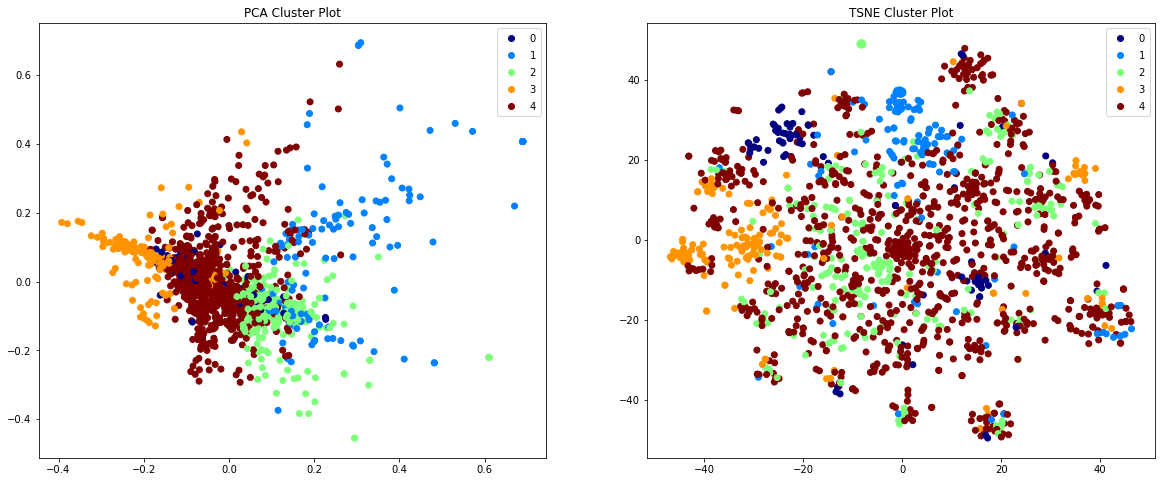

In [156]:
plot_tsne_pca(tfidf_mat, clusters)

In [150]:
#let's see cluster keywords
def get_top_keywords(data, clusters, labels, n_terms, categoryNames=None):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        if categoryNames is None:
            print('\nCluster {}'.format(i))
        else:
            print('\nCluster {}'.format(categoryNames[i]))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]][::-1]))
            
get_top_keywords(tfidf_mat, clusters, tfidf_vec.get_feature_names(), 10)


Cluster 0
woman,slut,bitch,’,rape,white,call,man,get,one

Cluster 1
stupid,bitch,ass,fuck,cunt,’,hoe,pussy,shit,beat

Cluster 2
bitch,dick,pussy,hoe,girl,’,like,im,fuck,aint

Cluster 3
women,men,rape,yesallmen,dick,like,many,dont,bitch,know

Cluster 4
whore,girl,dick,like,’,cunt,fuck,hoe,bitches,bitch


In [151]:
# Let's see actual categories keywords
#derailing', 'discredit', 'dominance', 'sexual_harassment','stereotype'
catNumbers = [0 if c == "derailing" else 1 if c == 'discredit' else 2 if c == 'dominance' else 3 if c == 'sexual_harassment' else 4 for c in categories]
get_top_keywords(tfidf_mat, np.array(catNumbers), tfidf_vec.get_feature_names(), 10, np.unique(categories))


Cluster derailing
women,rape,woman,men,dont,lol,every,want,man,dress

Cluster discredit
bitch,stupid,women,’,ass,like,girl,whore,hoe,slut

Cluster dominance
like,bitch,men,women,yesallmen,shut,get,whore,cock,account

Cluster sexual_harassment
dick,bitch,rape,cock,ass,fuck,suck,girl,like,pussy

Cluster stereotype
women,woman,dick,like,girl,one,bitch,bitches,yesallmen,going


Many words are shared between different categories, and its hard to tell some specifics, so it's hard to say that the categories are very sensible at first glance.
However, if we analyze the tweets that are labeled by different categories:

* derailing - usually tries to disregard women's issues by comparing with men, which is why those words are relevant. not too agressive language otherwise
* discredit - use of offensive vocabulary to insult people, usually women
* dominance - use of sexual language, usually to assert dominance of men over women
* sexual harrasment - use of sexual language
* stereotype - ?

In [37]:
homogeneity_score(clusters, catNumbers)

0.026353964448605518

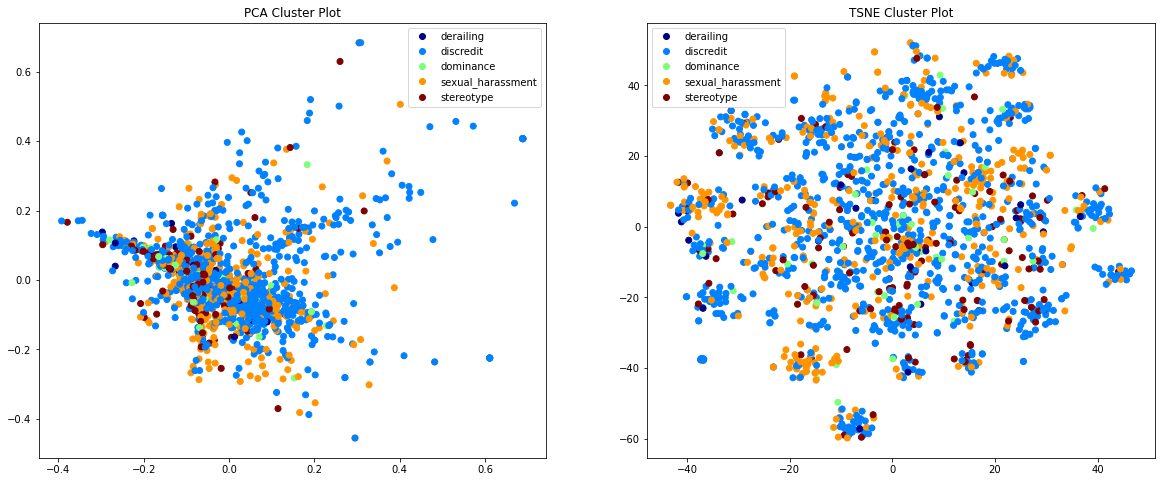

In [157]:
plot_tsne_pca(tfidf_mat, np.array(catNumbers), np.unique(categories))

## Second attempt - regular KMeans

Turns out its exactly the same as minibatch

In [59]:
km = KMeans(n_clusters=5)
km.fit(tfidf_mat)
clusters = np.array(km.labels_.tolist())
clusters

array([4, 4, 1, ..., 4, 3, 4])

In [68]:
#for each centroid, get ordered features by relevance
order_centroids =  km.cluster_centers_.argsort()[:, ::-1]
def getClusterWords(cluster, n=10):
    words = []
    for ind in order_centroids[cluster, :n]:
        words.append(tfidf_vec.get_feature_names()[ind])
    return ", ".join(words)

In [69]:
for i in range(5):
    print("Cluster {} words: {}".format(i, getClusterWords(i)))

Cluster 0 words: stupid, bitch, cunt, fuck, ’, fucking, ass, shit, u, lil
Cluster 1 words: hoe, pussy, bitch, ’, ass, “, ”, u, got, like
Cluster 2 words: whore, ’, fucking, like, bitch, shut, fuck, calling, shit, boo
Cluster 3 words: women, men, rape, like, dick, yesallmen, dont, bitch, many, want
Cluster 4 words: bitch, dick, girl, woman, like, ass, slut, fuck, bitches, cunt


We see some minor differences, but many words are the same, and we cant really infer a sensible topic/category to the generated clusters.

## Using average Word2Vec embeddings to represent documents

In [7]:
import gensim.downloader as api

In [8]:
word2vec = api.load('word2vec-google-news-300')

In [9]:
# first remove words (from previous tfidf result) which are not in word2vec vocabulary
words = tfidf_vec.get_feature_names()
notInVocab = [w not in word2vec for w in words]

In [10]:
englishwords.extend(list(np.array(words)[notInVocab]))

Let's first try making document represenatations out of average word2vec vectors

In [24]:
#maybe try using tf-idf weights?
tfidf_vec2 = TfidfVectorizer(max_df=0.9, 
                        max_features=10000,
                        min_df=5, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize,
                        norm='l1',
                        use_idf=False,
                        ngram_range=(1,1))

In [25]:
tfidf_mat = tfidf_vec2.fit_transform(tweets)
tfidf_mat.shape

(1568, 486)

In [26]:
# get average word2vec representation of each doc and try clustering
allwords = tfidf_vec2.get_feature_names()
wordvectors = np.zeros((len(allwords),300))
for i in range(len(allwords)):
    wordvectors[i,:] = word2vec[allwords[i]]

In [27]:
docVectors = np.dot(tfidf_mat.todense(),wordvectors)

In [15]:
def plot_tsne_pca2(data, labels, defLabels=None):
    max_label = max(labels)
 
    pca = PCA(n_components=2).fit_transform(data)
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data))
    f, ax = plt.subplots(1, 2, figsize=(20, 8))
    
    pts = ax[0].scatter(pca[:, 0], pca[:, 1], c=labels, cmap="jet")
    #print(pts)
    ax[0].set_title('PCA Cluster Plot')
    pts2 = ax[1].scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap="jet")
    ax[1].set_title('TSNE Cluster Plot')
    if defLabels is None:
        ax[0].legend(*pts.legend_elements())
        ax[1].legend(*pts2.legend_elements())
    else:
        ax[0].legend(pts.legend_elements()[0], defLabels)
        ax[1].legend(pts2.legend_elements()[0], defLabels)

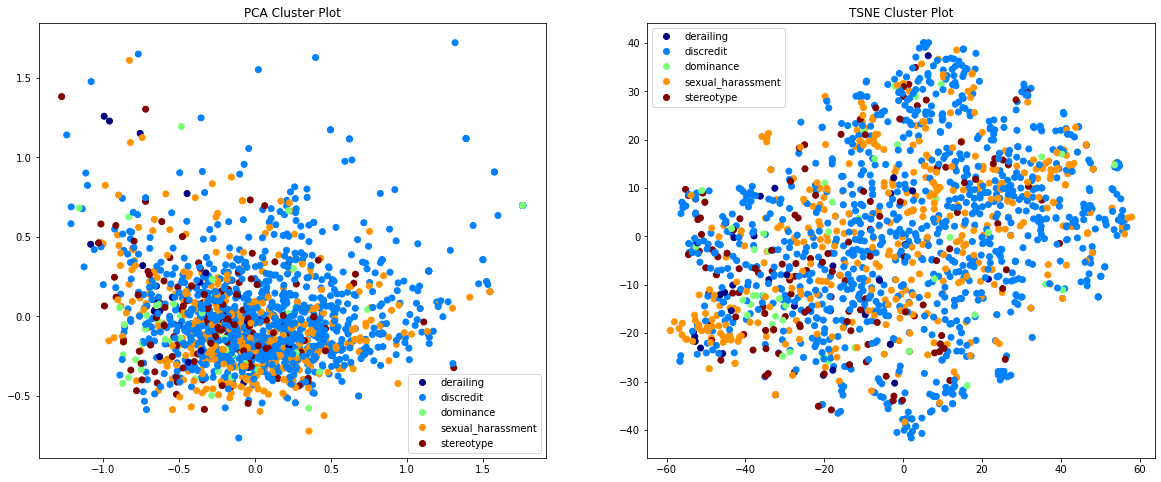

In [28]:
catNumbers = [0 if c == "derailing" else 1 if c == 'discredit' else 2 if c == 'dominance' else 3 if c == 'sexual_harassment' else 4 for c in categories]
plot_tsne_pca2(docVectors, catNumbers, np.unique(categories))

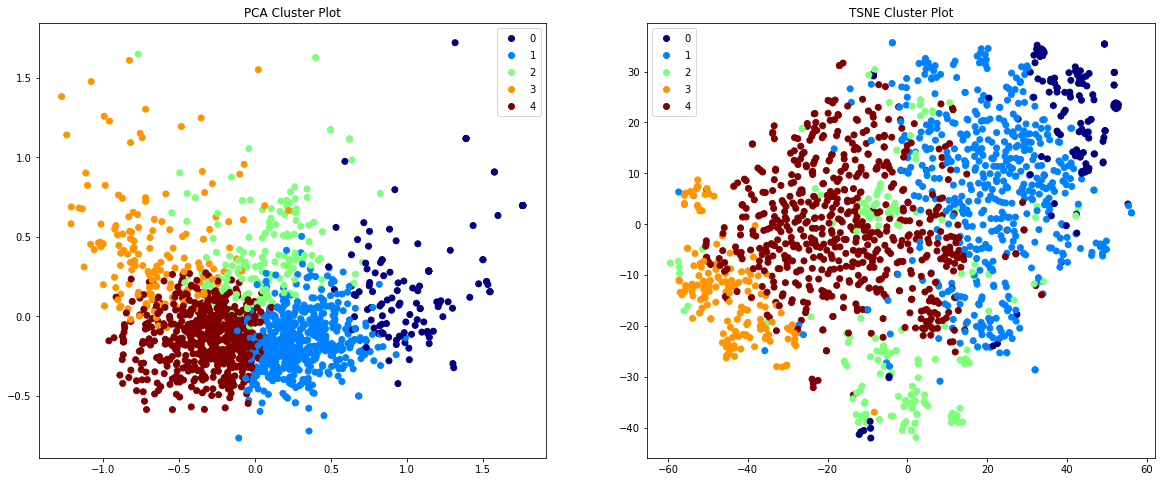

In [29]:
km = KMeans(n_clusters=5)
km.fit(docVectors)
plot_tsne_pca2(docVectors, km.labels_.tolist())

In [30]:
homogeneity_score(km.labels_.tolist(), catNumbers)

0.022371908005195316

In [18]:
for i in range(5):
    clwords = [x[0] for x in word2vec.most_similar([km.cluster_centers_[i]], topn=5)]
    print("cluster {} top words: {}".format(i, ", ".join(clwords)))

cluster 0 top words: woman, collapse_Betsy_Sathers, women, slut, sensual_beings
cluster 1 top words: Cassell_chirped, ROBERT_BLAGOJEVICH, RUSH_Yeah, BLATHER_1, samantharonson_@
cluster 2 top words: hoe, ass_nigga, b_*_tches, samantharonson_@, Ding_dang
cluster 3 top words: bitch, fucking, fuck, shit, cunt
cluster 4 top words: samantharonson_@, shit, fucking, dayum, freaken


In [20]:
uniquecategories = np.unique(categories)
for i in range(len(uniquecategories)):
    indices = np.where(np.array(categories) == uniquecategories[i])
    centroid = np.array(np.mean(docVectors[indices],axis=0)).flatten()
    #print(np.array(centroid).flatten())
    clwords = [x[0] for x in word2vec.most_similar([centroid], topn=5)]
    print("cluster {} top words: {}".format(uniquecategories[i], ", ".join(clwords)))

cluster derailing top words: RUSH_Yeah, Er_um, Sorry_ma'am, Can'tI, ROBERT_BLAGOJEVICH
cluster discredit top words: samantharonson_@, jennajameson_@, bitch, Ding_dang, fucking
cluster dominance top words: samantharonson_@, jennajameson_@, Ding_dang, Cassell_chirped, ROBERT_BLAGOJEVICH
cluster sexual_harassment top words: samantharonson_@, jennajameson_@, Ding_dang, Whadda, Jeeze
cluster stereotype top words: samantharonson_@, jennajameson_@, Jeeze, ROBERT_BLAGOJEVICH, hollyrpeete_@


Not really comprehensible, seems like the centroids of all documents of different categories are very close together tho

## Grouping documents by category & using word2vec embeddings

In [39]:
# concat all same-category docs into 1, measure similarity between keyword vectors
uniquecategories = np.unique(categories)
tweetsNP = np.array(tweets)
tweetsByCategory = []
for i in range(len(uniquecategories)):
    indices = np.where(np.array(categories) == uniquecategories[i])
    tweetsByCategory.append(" ".join(list(tweetsNP[indices])))

In [97]:
# Clean up tweets
tfidf_vec3 = TfidfVectorizer(max_df=1.0,
                        max_features=10000,
                        min_df=1, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize, 
                        ngram_range=(1,1))

In [98]:
tfidf_mat3 = tfidf_vec3.fit_transform(tweetsByCategory)
tfidf_mat3.shape

(5, 4021)

In [138]:
#prepare a single vector for each document based on top 20 keywords, weighted by tfidf, and then normalized
documentVectors = np.zeros((300,5))
npFeatures = np.array(tfidf_vec3.get_feature_names())
for i in range(5):
    row = np.array(tfidf_mat3.getrow(i).todense()).flatten()
    indices = row.argsort()[::-1][:30]
    print(uniquecategories[i], npFeatures[indices])
    for ix in indices:
        if npFeatures[ix] in word2vec:
            documentVectors[:,i] += word2vec[npFeatures[ix]] * row[ix]

derailing ['women' 'rape' 'woman' 'dumbass' 'dont' 'bitch' 'forward' 'men' 'come'
 'sharia' 'slutty' 'birth' 'like' 'dick' 'lol' 'every' 'asked' 'sign'
 'get' 'whore' 'want' 'girl' 'told' 'assault' 'isnt' 'dress' 'free'
 'sexism' 'sexual' 'fat']
discredit ['bitch' 'like' '’' 'women' 'stupid' 'girl' 'pussy' 'ass' 'hoe' 'fuck'
 'whore' 'bitches' 'dick' 'woman' 'cunt' 'u' 'slut' 'shit' 'dont' 'get'
 'im' 'yo' 'know' 'youre' 'got' 'fucking' '“' 'one' 'na' '”']
dominance ['like' 'bitch' 'women' 'men' 'whore' 'girl' 'rights' 'im' 'yesallmen'
 'dont' 'know' 'get' 'cock' 'girls' 'shut' 'maledominance' 'shoo' '’'
 'dick' 'one' 'youre' 'hoe' 'show' 'thanks' 'would' 'need' 'little'
 'account' 'womens' 'much']
sexual_harassment ['bitch' 'dick' 'fuck' 'rape' 'girl' 'pussy' 'like' '’' 'ass' 'cock'
 'women' 'suck' 'u' 'dont' 'im' 'cunt' 'woman' 'whore' 'stupid' 'na' 'got'
 'hoe' 'get' 'love' 'fucking' 'shit' 'gon' 'go' 'big' 'beat']
stereotype ['women' 'bitch' 'woman' 'dick' 'girl' 'like' 'bitches' '

In [135]:
#normalize
documentVectors = documentVectors / np.linalg.norm(documentVectors, axis=0)

In [136]:
# compute cosine similarity...
similarities = documentVectors.T.dot(documentVectors)

In [137]:
pd.DataFrame(similarities, columns=uniquecategories, index=uniquecategories)

,derailing,discredit,dominance,sexual_harassment,stereotype
derailing,1.000000,0.813895,0.894238,0.824762,0.909168
discredit,0.813895,1.000000,0.892335,0.977255,0.931885
dominance,0.894238,0.892335,1.000000,0.890353,0.945924
sexual_harassment,0.824762,0.977255,0.890353,1.000000,0.925149
stereotype,0.909168,0.931885,0.945924,0.925149,1.000000


Derailing & discredit are most dissimilar categories. In general derailing is quite different than all the other topics. This is expected as documents labeled as derailing have the lowest frequency of directly offensive unigrams. Sexual harrasment & discredit are most similar in terms of language, followed by dominance & stereotype. Regardless, all categories are still very "similar" globally in the embedding space. 